In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


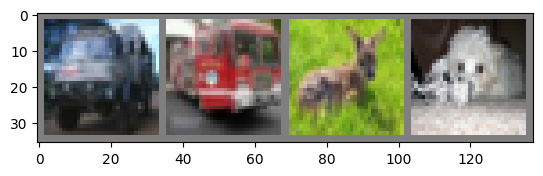

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [7]:
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scales=4, stride=1, bottleneck_width=4):
        super(Res2NetBlock, self).__init__()
        self.scales = scales
        self.bottleneck_width = bottleneck_width
        
        # 计算每个尺度的卷积通道数
        self.d = out_channels // scales
        
        # 定义每个尺度的卷积
        self.convs = nn.ModuleList()
        for i in range(scales):
            in_ch = in_channels if i == 0 else self.d
            out_ch = self.d if i < scales - 1 else out_channels
            self.convs.append(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
            )
        
        # 批归一化和激活
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # 计算每个尺度的卷积
        out = [conv(x) for conv in self.convs]
        
        # 合并各个尺度的输出
        out = torch.cat(out, dim=1)
        
        # 批归一化和激活
        out = self.bn(out)
        out = self.relu(out)
        
        return out


In [27]:
class Res2Net(nn.Module):
    def __init__(self, num_classes=10, scales=4, bottleneck_width=4):
        super(Res2Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 更正层次之间通道数的配置
        self.layer1 = self._make_layer(64, 64, scales, bottleneck_width, num_blocks=3)
        self.layer2 = self._make_layer(64, 128, scales, bottleneck_width, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, scales, bottleneck_width, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, scales, bottleneck_width, num_blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, scales, bottleneck_width, num_blocks, stride=1):
        layers = []
        layers.append(Res2NetBlock(in_channels, out_channels, scales, stride, bottleneck_width))
        for _ in range(1, num_blocks):
            layers.append(Res2NetBlock(out_channels, out_channels, scales, 1, bottleneck_width))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [28]:
net = Res2Net(num_classes=10, scales=4, bottleneck_width=4)

In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [35]:
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [40]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss
# Evaluation
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / len(test_loader)
    acc = 100. * correct / total
    print('Epoch:Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Res2Net Block
class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scales=4, stride=1):
        super(Res2NetBlock, self).__init__()
        self.scales = scales
        self.d = out_channels // scales  # 每个尺度的通道数
        self.convs = nn.ModuleList()

        # 定义每个尺度的卷积
        for i in range(scales):
            in_ch = in_channels if i == 0 else self.d
            out_ch = self.d if i < scales - 1 else out_channels
            self.convs.append(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
            )

        # 批归一化和激活
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)  # 将多个尺度的输出拼接起来
        out = self.bn(out)
        out = self.relu(out)
        return out


# 网络主体结构
class Net(nn.Module):
    def __init__(self, scales=4):
        super(Net, self).__init__()
        self.conv1 = Res2NetBlock(3, 6, scales)  # 使用Res2NetBlock替代原始卷积
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = Res2NetBlock(6, 16, scales)  # 使用Res2NetBlock替代原始卷积
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 使用Res2Net块输出并激活
        x = self.pool(F.relu(self.conv2(x)))  # 使用Res2Net块输出并激活
        x = torch.flatten(x, 1)  # 展平，除了batch维度
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 创建网络实例
net = Net(scales=4).cuda()


In [ ]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Res2Net Block
class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, scale=4, width=26):
        super(Res2NetBlock, self).__init__()
        self.scale = scale
        self.width = width
        self.mid_channels = width * scale

        self.conv1 = nn.Conv2d(in_channels, self.mid_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(self.mid_channels)
        self.relu = nn.ReLU(inplace=True)

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(scale - 1):
            self.convs.append(nn.Conv2d(width, width, kernel_size=3, padding=1, bias=False))
            self.bns.append(nn.BatchNorm2d(width))

        self.conv3 = nn.Conv2d(self.mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        split_size = self.width
        spx = torch.split(out, split_size, 1)
        ys = []
        ys.append(spx[0])
        for i in range(1, self.scale):
            ys.append(self.relu(self.bns[i-1](self.convs[i-1](spx[i])) + ys[i-1]))

        out = torch.cat(ys, 1)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Res2Net Model
class Res2Net(nn.Module):
    def __init__(self, block, layers, num_classes=10, scale=4, width=26):
        super(Res2Net, self).__init__()
        self.in_channels = 64
        self.scale = scale
        self.width = width

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, scale=self.scale, width=self.width))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, scale=self.scale, width=self.width))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5)),
])

# 加载数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res2Net(Res2NetBlock, [3, 3, 3], num_classes=10, scale=4, width=16).to(device)
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

# 训练和测试函数
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        train_loss += loss.item()
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))

def test(epoch):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    avg_loss = test_loss / len(testloader)
    acc = 100. * correct / total
    print('Epoch:Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss

# 训练循环
for epoch in range(50):
    train(epoch)
    test_loss =test(epoch)
    scheduler.step(test_loss, epoch=epoch)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, train loss: 1.790485, acc: 33.716% (16858/50000)
Epoch:Test Loss: 1.390998 | Acc: 48.500% (4850/10000)


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:1013: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1, train loss: 1.240648, acc: 54.906% (27453/50000)
Epoch:Test Loss: 1.429329 | Acc: 50.230% (5023/10000)
Epoch: 2, train loss: 1.024425, acc: 63.442% (31721/50000)
Epoch:Test Loss: 1.170635 | Acc: 59.110% (5911/10000)
Epoch: 3, train loss: 0.910826, acc: 67.510% (33755/50000)
Epoch:Test Loss: 1.050989 | Acc: 64.320% (6432/10000)
Epoch: 4, train loss: 0.826312, acc: 70.826% (35413/50000)
Epoch:Test Loss: 1.210453 | Acc: 63.300% (6330/10000)
Epoch: 5, train loss: 0.748749, acc: 73.788% (36894/50000)
Epoch:Test Loss: 0.831807 | Acc: 71.270% (7127/10000)
Epoch: 6, train loss: 0.718241, acc: 75.140% (37570/50000)
Epoch:Test Loss: 0.944607 | Acc: 69.720% (6972/10000)
Epoch: 7, train loss: 0.688455, acc: 76.098% (38049/50000)
Epoch:Test Loss: 1.294273 | Acc: 62.270% (6227/10000)
Epoch: 8, train loss: 0.665275, acc: 77.022% (38511/50000)
Epoch:Test Loss: 1.130460 | Acc: 64.500% (6450/10000)
Epoch: 9, train loss: 0.651522, acc: 77.612% (38806/50000)
Epoch:Test Loss: 0.936901 | Acc: 69.7

In [ ]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [12]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/cnn.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [6]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，我们使用基本的Block
    基础块没有维度压缩，所以expansion=1
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [7]:
# 测试
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


In [8]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [9]:
# 测试
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


In [10]:
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [11]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [12]:
net = ResNet18().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [13]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [14]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Training
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [16]:
# Evaluation
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / len(test_loader)
    acc = 100. * correct / total
    print('Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss


In [17]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [18]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss
# Evaluation
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / len(test_loader)
    acc = 100. * correct / total
    print('Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss


In [19]:
for epoch in range(start_epoch, 50):
    train_loss = train(epoch)
    test_loss = test(epoch)
    print('Epoch %d | Train Loss: %.6f | Test Loss: %.6f' % (epoch, train_loss, test_loss))

    scheduler.step(test_loss, epoch=epoch)  # 如果是 ReduceLROnPlateau 类型的 scheduler


Epoch: 0, train loss: 1.837289, acc: 34.844% (17422/50000)
Test Loss: 1.394777 | Acc: 47.890% (4789/10000)
Epoch 0 | Train Loss: 1.837289 | Test Loss: 1.394777


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1350: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1, train loss: 1.287498, acc: 53.294% (26647/50000)
Test Loss: 1.288672 | Acc: 53.550% (5355/10000)
Epoch 1 | Train Loss: 1.287498 | Test Loss: 1.288672
Epoch: 2, train loss: 1.026461, acc: 63.580% (31790/50000)
Test Loss: 0.983380 | Acc: 65.000% (6500/10000)
Epoch 2 | Train Loss: 1.026461 | Test Loss: 0.983380
Epoch: 3, train loss: 0.829200, acc: 70.724% (35362/50000)
Test Loss: 0.911941 | Acc: 68.850% (6885/10000)
Epoch 3 | Train Loss: 0.829200 | Test Loss: 0.911941
Epoch: 4, train loss: 0.704869, acc: 75.322% (37661/50000)
Test Loss: 0.699549 | Acc: 75.550% (7555/10000)
Epoch 4 | Train Loss: 0.704869 | Test Loss: 0.699549
Epoch: 5, train loss: 0.589245, acc: 79.520% (39760/50000)
Test Loss: 0.793440 | Acc: 73.570% (7357/10000)
Epoch 5 | Train Loss: 0.589245 | Test Loss: 0.793440
Epoch: 6, train loss: 0.521570, acc: 82.082% (41041/50000)
Test Loss: 0.642697 | Acc: 78.470% (7847/10000)
Epoch 6 | Train Loss: 0.521570 | Test Loss: 0.642697
Epoch: 7, train loss: 0.470782, acc: 83.

In [ ]:
for epoch in range(start_epoch, 50):
    loss = train(epoch)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)

In [20]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')

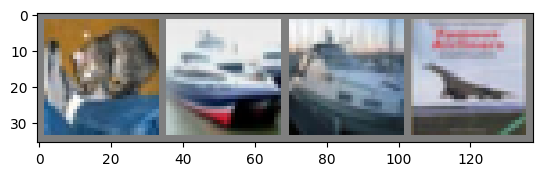

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane
Accuracy of the network on the 10000 test images: 90 %
Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 83 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %


In [20]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))